In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import pygal
from tqdm import tqdm
from abcd.local.paths import core_path, output_path
from abcd.data.read_data import get_subjects_events, add_event_vars, add_subject_vars, filter_events, filter_subjects
import abcd.data.VARS as VARS
from abcd.data.define_splits import SITES, save_restore_sex_fmri_splits
from abcd.data.divide_with_splits import divide_events_by_splits
from abcd.data.var_tailoring.residualization import residualize
from abcd.data.var_tailoring.normalization import normalize_var
from abcd.analysis.methods.sklearn_cca import fit_cca, add_cca_covariates
from abcd.plotting.seaborn.scatter import plot_scatter
from abcd.plotting.seaborn.correlations import plot_correlations
from abcd.plotting.matplotlib.cca_plot import plot_cca_rotations
from abcd.plotting.pygal.rendering import display_html

In [3]:
k = 5
subjects_df, events_df = get_subjects_events()
splits = save_restore_sex_fmri_splits(k=k)
# Remove subjects with "don't know" or "refuse to answer" sex
subjects_df = subjects_df[subjects_df['kbi_sex_assigned_at_birth'].isin([1.0, 2.0])]
events_df = filter_events(subjects_df, events_df)
events_df = events_df.dropna()
print("There are {} visits for {} subjects".format(len(events_df), len(subjects_df)))

There are 19328 visits for 9756 subjects


In [4]:
# Add demographic information to residualize
subjects_df = add_subject_vars(subjects_df, table_path=VARS.DEMO_PATH, vars=list(VARS.DEMO_VARS.keys()))
events_df = filter_events(subjects_df, events_df)
events_df = events_df.dropna()
print("There are {} visits for {} subjects".format(len(events_df), len(subjects_df)))

100%|█████████████████████████████████████████████████████████████████████████████| 9756/9756 [00:35<00:00, 272.06it/s]


There are 19327 visits for 9755 subjects


In [5]:
# Plot demographic information
plot = pygal.Box(logarithmic=True)
plot.title = 'Income level per race/ethnicity'
race_names = {1: "White", 2: "Black", 3: "Hispanic", 4: "Asian", 5: "Other"}
for race, race_name in race_names.items():
    race_subjects = subjects_df.loc[(subjects_df['race_ethnicity'] == race)]
    plot.add(race_name, list(race_subjects['demo_comb_income_v2']))
display_html(plot)

In [6]:
# Add the sex and demographic information to the events df
events_df = pd.merge(events_df, subjects_df[['src_subject_id','kbi_sex_assigned_at_birth', 'race_ethnicity', 'demo_comb_income_v2']], on='src_subject_id', how='left')

In [7]:
# Add neurocognition scores
events_df = add_event_vars(events_df, VARS.NIH_PATH, vars=list(VARS.NIH_TESTS_uncorrected.keys()))
events_df = events_df.dropna()
subjects_df = filter_subjects(subjects_df, events_df)
print("There are {} visits for {} subjects".format(len(events_df), len(subjects_df)))

There are 9318 visits for 9208 subjects


In [8]:
# Plot neurocognition scores
plot = pygal.Box()  #truncate_legend=-1
plot.title = 'NIH Toolbox Neurocognition Scores'
for var_id, var_name in VARS.NIH_TESTS_uncorrected.items():
    plot.add(var_name, list(events_df[var_id]))
display_html(plot)

In [9]:
# Add CBCL scores
events_df = add_event_vars(events_df, VARS.CBCL_PATH, vars=list(VARS.CBCL_SCORES_raw.keys()))
events_df = events_df.dropna()
subjects_df = filter_subjects(subjects_df, events_df)
print("There are {} visits for {} subjects".format(len(events_df), len(subjects_df)))

There are 9300 visits for 9204 subjects


In [10]:
for visitname in set(events_df['eventname']):
    print("{} visits for {}".format(len(events_df.loc[(events_df['eventname'] == visitname)]), visitname))
    
# Leave only the baseline visits
events_df = events_df.loc[(events_df['eventname'] == 'baseline_year_1_arm_1')]

9195 visits for baseline_year_1_arm_1
74 visits for 4_year_follow_up_y_arm_1
31 visits for 2_year_follow_up_y_arm_1


In [11]:
# Plot CBCL scores
plot = pygal.Box()
plot.title = 'CBCL Scores'
for var_id, var_name in VARS.CBCL_SCORES_raw.items():
    plot.add(var_name, list(events_df[var_id]))
display_html(plot)

In [12]:
# Residualize the sex, age, race and parental income effects from all the feature and target scores
# Normalize CBCL and Neurocognition scores
all_vars = list(VARS.CBCL_SCORES_raw.keys()) + list(VARS.NAMED_CONNECTIONS.keys()) + list(VARS.NIH_TESTS_uncorrected.keys())
for var_id in tqdm(list(VARS.CBCL_SCORES_raw.keys()) + list(VARS.NIH_TESTS_uncorrected.keys())):
    events_df = residualize(events_df, var_id, var_id, 
                covs = ["interview_age", "kbi_sex_assigned_at_birth", "race_ethnicity", "demo_comb_income_v2"],
                references = {"kbi_sex_assigned_at_birth": 1.0, "race_ethnicity": 1.0})
    events_df = normalize_var(events_df, var_id, var_id)
    
for var_id in tqdm(VARS.NAMED_CONNECTIONS.keys()):
    events_df = residualize(events_df, var_id, var_id, 
                covs = ["interview_age", "kbi_sex_assigned_at_birth", "race_ethnicity", "demo_comb_income_v2"],
                references = {"kbi_sex_assigned_at_birth": 1.0, "race_ethnicity": 1.0})

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:03<00:00, 53.28it/s]


In [13]:
from abcd.data.assert_significance import is_different_from_mean, k_greatest_stat, k_greatest_std

print("There are initially {} connections".format(len(VARS.NAMED_CONNECTIONS.keys())))

p_threshold = 0.01
significant_connections = []
for var_id in tqdm(VARS.NAMED_CONNECTIONS.keys()):
    if is_different_from_mean(events_df[var_id], p_threshold=p_threshold):
        significant_connections.append(var_id)
        
print("With p={}, there are {} significant connections".format(p_threshold, len(significant_connections)))

# Select the 20 most significant ones
k = 20
connections = list(VARS.NAMED_CONNECTIONS.keys())
greatest_stat = k_greatest_stat(events_df, vars=connections, k=k)
print("{} greatest w.r.t. t-statistic: {}".format(k, [VARS.NAMED_CONNECTIONS[c] for c in greatest_stat]))
greatest_std = k_greatest_std(events_df, vars=connections, k=k)
print("{} greatest w.r.t. std: {}".format(k, [VARS.NAMED_CONNECTIONS[c] for c in greatest_std]))

in_common = [x for x in greatest_stat if x in greatest_std]
print("In common: {}".format([VARS.NAMED_CONNECTIONS[c] for c in in_common]))

There are initially 169 connections


100%|██████████████████████████████████████████████████████████████████████████████| 169/169 [00:00<00:00, 1331.26it/s]

With p=0.01, there are 169 significant connections
20 greatest w.r.t. t-statistic: ['rspltp-rspltp', 'cgc-cgc', 'vs-vs', 'ca-ca', 'dt-dt', 'ad-ad', 'dla-dla', 'smm-smm', 'vta-vta', 'fo-fo', 'smh-smh', 'sa-sa', 'ad-cgc', 'cgc-ad', 'n-n', 'ad-smm', 'smm-ad', 'dt-n', 'n-dt', 'cgc-sa']


20 greatest w.r.t. std: ['ca-ca', 'smm-smm', 'rspltp-rspltp', 'sa-sa', 'ca-rspltp', 'rspltp-ca', 'ca-sa', 'sa-ca', 'vs-vs', 'smh-smm', 'smm-smh', 'ca-smm', 'smm-ca', 'ca-vs', 'vs-ca', 'rspltp-sa', 'sa-rspltp', 'rspltp-vs', 'vs-rspltp', 'sa-smm']
In common: ['rspltp-rspltp', 'vs-vs', 'ca-ca', 'smm-smm', 'sa-sa']


In [14]:
# Leave only the visits with at least internalizing or externalizing CBCL score above the mean + 1 std
cbcl_means, cbcl_stds = dict(), dict()
for var_id, var_name in VARS.CBCL_SCORES_raw.items():
    cbcl_means[var_id], cbcl_stds[var_id] = np.mean(events_df[var_id]), np.std(events_df[var_id])

cbcl_subset_df = events_df.loc[((events_df['cbcl_scr_syn_internal_r'] >= (cbcl_means['cbcl_scr_syn_internal_r'] + 1*cbcl_stds['cbcl_scr_syn_internal_r'])) | 
                                (events_df['cbcl_scr_syn_external_r'] >= (cbcl_means['cbcl_scr_syn_external_r'] + 1*cbcl_stds['cbcl_scr_syn_external_r'])))]

print("In the CBCL-filtered data frame, there are {} visits".format(len(cbcl_subset_df)))

In the CBCL-filtered data frame, there are 1743 visits


In [15]:
# Plot CBCL scores
plot = pygal.Box()
plot.title = 'CBCL Scores after leaving visits with internal or external >= mean + 1 std'
for var_id, var_name in VARS.CBCL_SCORES_raw.items():
    plot.add(var_name, list(cbcl_subset_df[var_id]))
display_html(plot)

In [29]:
# Divide events into training, validation and testing
ood_site_id = SITES[0]
#events_train, events_id_test, events_ood_test = divide_events_by_splits(cbcl_subset_df, splits, ood_site_id)
events_train, events_id_test, events_ood_test = divide_events_by_splits(events_df, splits, ood_site_id)
print("Nr. events train: {}, val: {}, test: {}".format(len(events_train), len(events_id_test), len(events_ood_test)))

Nr. events train: 7147, val: 1770, test: 278


In [31]:
# Change names
events_train, events_id_test, events_ood_test = events_train.rename(columns=VARS.CBCL_SCORES_raw), events_id_test.rename(columns=VARS.CBCL_SCORES_raw), events_ood_test.rename(columns=VARS.CBCL_SCORES_raw)
events_train, events_id_test, events_ood_test = events_train.rename(columns=VARS.NIH_TESTS_uncorrected), events_id_test.rename(columns=VARS.NIH_TESTS_uncorrected), events_ood_test.rename(columns=VARS.NIH_TESTS_uncorrected)
events_train, events_id_test, events_ood_test = events_train.rename(columns=VARS.NAMED_CONNECTIONS), events_id_test.rename(columns=VARS.NAMED_CONNECTIONS), events_ood_test.rename(columns=VARS.NAMED_CONNECTIONS)
fmri_columns = [VARS.NAMED_CONNECTIONS[c] for c in greatest_stat]
cbcl_columns = list(VARS.CBCL_SCORES_raw.values()) 
nih_columns = list(VARS.NIH_TESTS_uncorrected.values()) 

In [18]:
# First CCA analysis: RS fMRI connectivity & CBCL scores
nr_components = 3
cca_model, events_train = fit_cca(events_train, fmri_columns, cbcl_columns, nr_components=nr_components)
add_cca_covariates(events_id_test, cca_model, fmri_columns, cbcl_columns, nr_components=nr_components)
add_cca_covariates(events_ood_test, cca_model, fmri_columns, cbcl_columns, nr_components=nr_components)
cc_x_cols, cc_y_cols = ["CC{}_X".format(dim+1) for dim in range(nr_components)], ["CC{}_Y".format(dim+1) for dim in range(nr_components)]


Covariate on dimension 1 has correlation 0.26
Covariate on dimension 2 has correlation 0.20
Covariate on dimension 3 has correlation 0.18
Covariate on dimension 1 has correlation 0.17
Covariate on dimension 2 has correlation -0.06
Covariate on dimension 3 has correlation 0.05
Covariate on dimension 1 has correlation 0.11
Covariate on dimension 2 has correlation 0.12
Covariate on dimension 3 has correlation -0.17


In [32]:
# Second CCA analysis: RS fMRI connectivity & NIH scores
nr_components = 3
cca_model, events_train = fit_cca(events_train, fmri_columns, nih_columns, nr_components=nr_components)
add_cca_covariates(events_id_test, cca_model, fmri_columns, nih_columns, nr_components=nr_components)
add_cca_covariates(events_ood_test, cca_model, fmri_columns, nih_columns, nr_components=nr_components)
cc_x_cols, cc_y_cols = ["CC{}_X".format(dim+1) for dim in range(nr_components)], ["CC{}_Y".format(dim+1) for dim in range(nr_components)]


Covariate on dimension 1 has correlation 0.23
Covariate on dimension 2 has correlation 0.10
Covariate on dimension 3 has correlation 0.07
Covariate on dimension 1 has correlation 0.22
Covariate on dimension 2 has correlation 0.06
Covariate on dimension 3 has correlation 0.05
Covariate on dimension 1 has correlation 0.23
Covariate on dimension 2 has correlation 0.03
Covariate on dimension 3 has correlation 0.03


<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

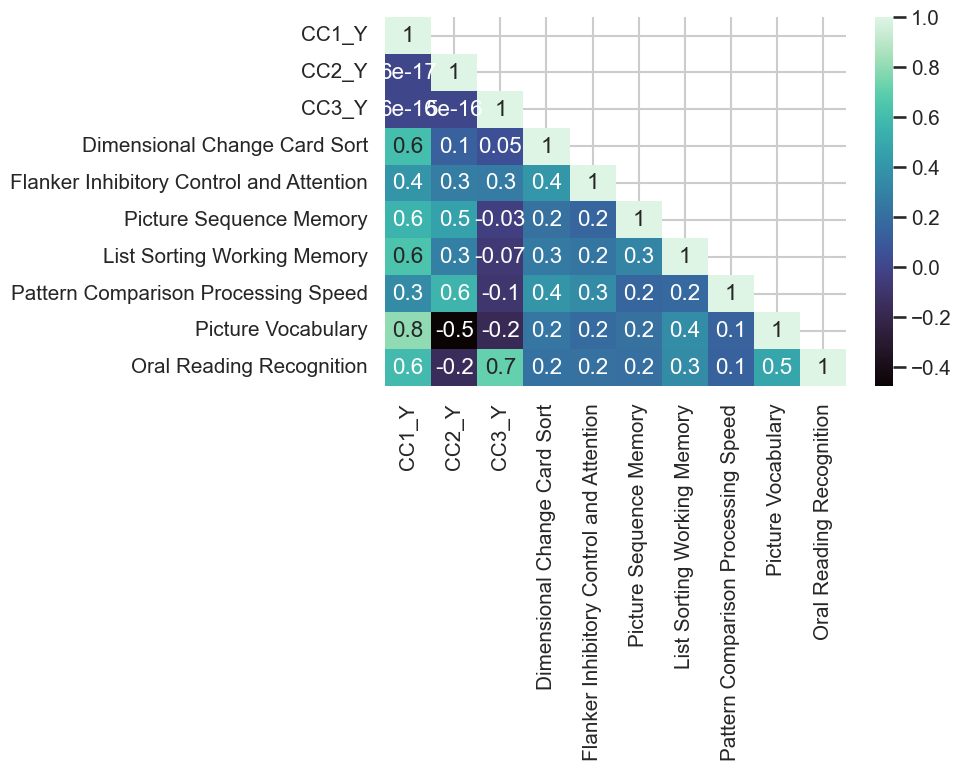

In [33]:
plot_correlations(events_train, columns=cc_y_cols + nih_columns)

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

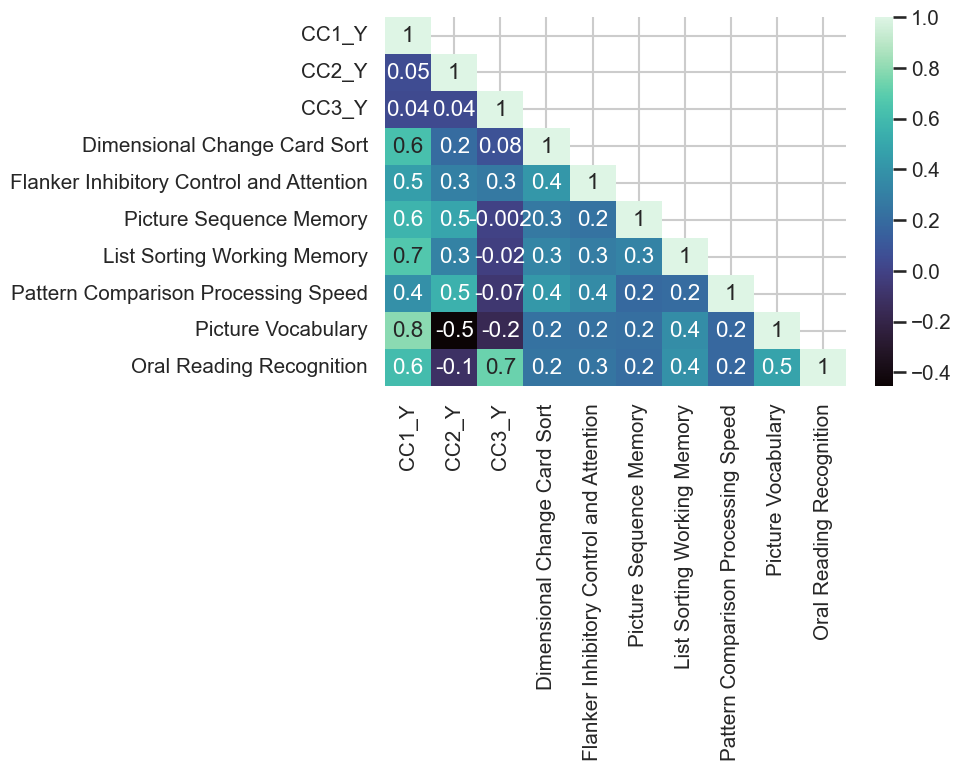

In [34]:
plot_correlations(events_id_test, columns=cc_y_cols + nih_columns)

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

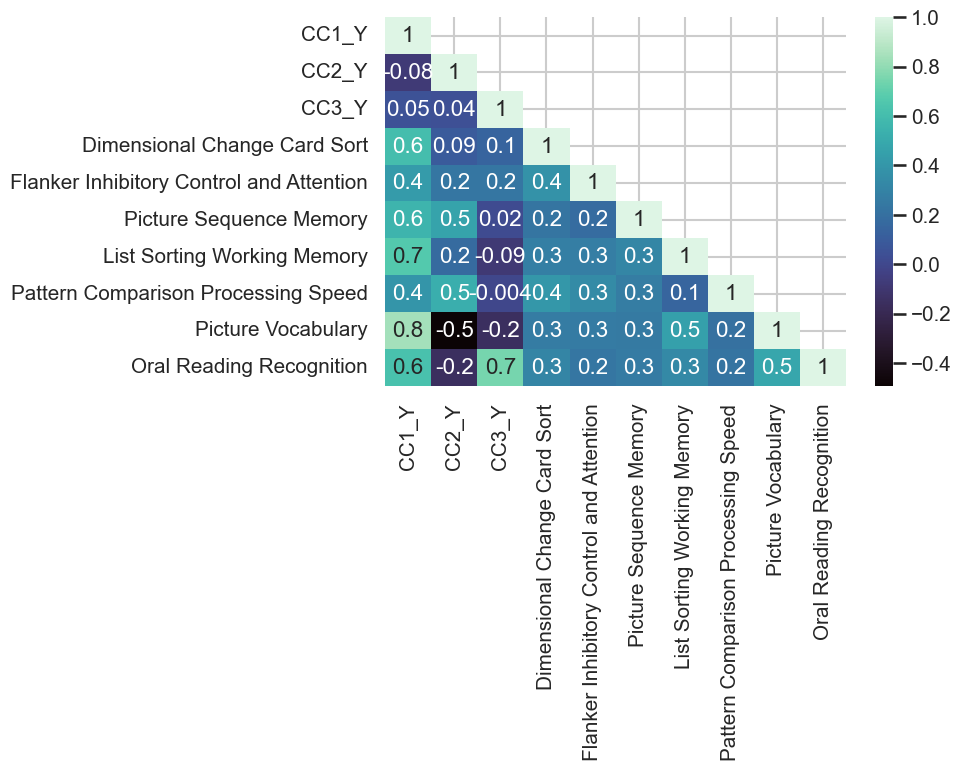

In [35]:
plot_correlations(events_ood_test, columns=cc_y_cols + nih_columns)

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

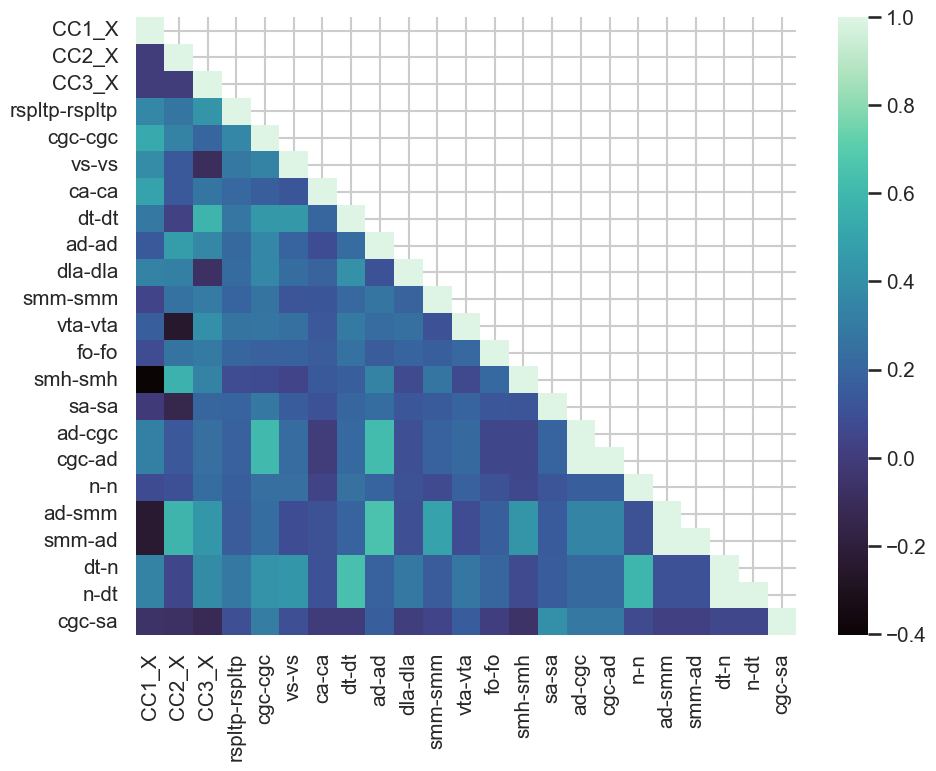

In [36]:
plot_correlations(events_train, columns=cc_x_cols + fmri_columns, annot=False)

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

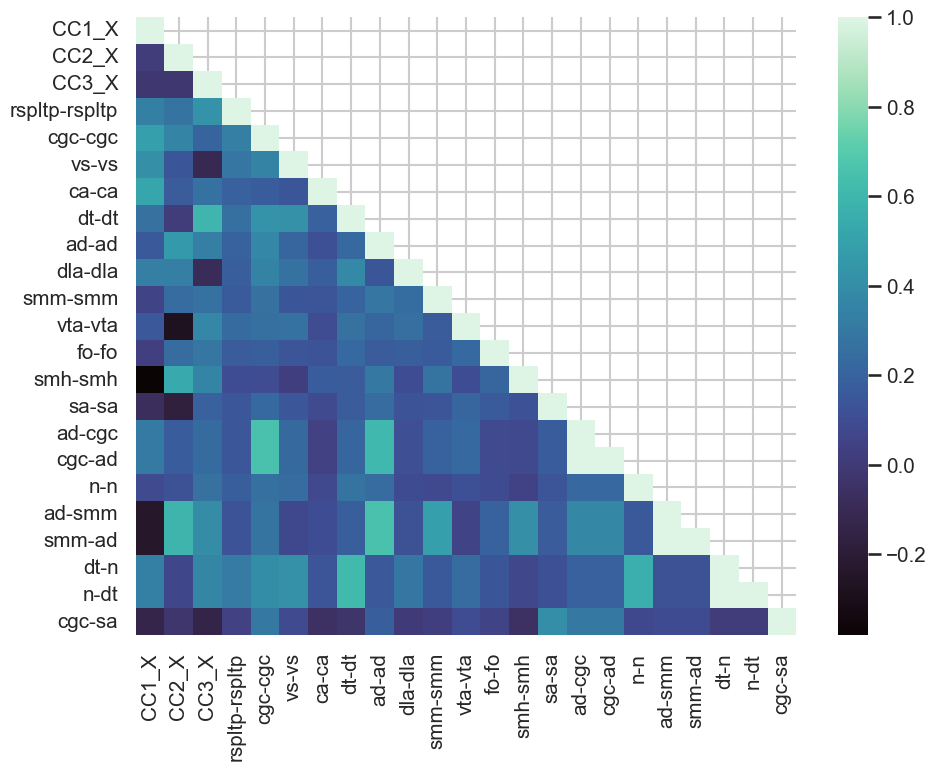

In [37]:
plot_correlations(events_id_test, columns=cc_x_cols + fmri_columns, annot=False)

<module 'matplotlib.pyplot' from 'C:\\Users\\camgonza\\AppData\\Local\\anaconda3\\envs\\abcd\\Lib\\site-packages\\matplotlib\\pyplot.py'>

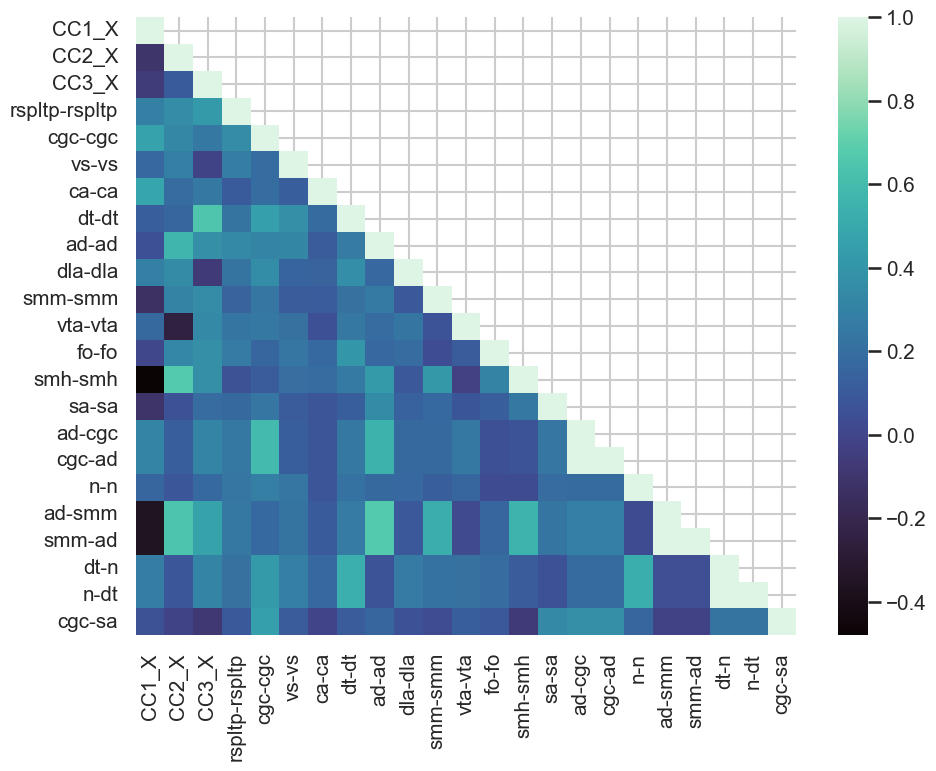

In [38]:
plot_correlations(events_ood_test, columns=cc_x_cols + fmri_columns, annot=False)